# UsahaKu - Predictive Time Series

## Import Library

In [1]:
import numpy as np
import pandas as pd
import requests
import pickle
from io import StringIO
import matplotlib.pyplot as plt
import matplotlib.colors as m
from google.colab import drive
import matplotlib.ticker as ticker

import tensorflow as tf
from keras import layers, models, metrics
from keras.layers import Dense, LSTM, Dropout
from tensorflow.data import Dataset
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.models import load_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
print(tf.__version__)

2.18.0


In [3]:
print(sklearn.__version__)

1.6.1


## Data Loading

In [4]:
url ='https://raw.githubusercontent.com/UsahaKu-DBS/Machine-Learning/refs/heads/main/timeseries_2020_2023.csv'

df = pd.read_csv(url)
df

,Tanggal,Pemasukan,Pengeluaran,Net_Income
0,2020-01-01,533650.674272,261709.864433,271940.809839
1,2020-01-02,522646.460900,343257.251688,179389.209212
2,2020-01-03,510077.500875,278691.752404,231385.748471
3,2020-01-04,517153.004379,287106.830289,230046.174089
4,2020-01-05,476311.130499,308548.772386,167762.358113
...,...,...,...,...
1456,2023-12-27,660910.221802,298762.903246,362147.318556
1457,2023-12-28,705294.940719,346572.179452,358722.761267
1458,2023-12-29,732865.717533,334864.958148,398000.759385
1459,2023-12-30,706555.710445,316438.642727,390117.067717


## Exploratory Data Analysis

In [5]:
# Konversi kolom tanggal menjadi datetime
df['Tanggal'] = pd.to_datetime(df['Tanggal'])
df.set_index('Tanggal', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1461 entries, 2020-01-01 to 2023-12-31
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Pemasukan    1461 non-null   float64
 1   Pengeluaran  1461 non-null   float64
 2   Net_Income   1461 non-null   float64
dtypes: float64(3)
memory usage: 45.7 KB


In [6]:
df.describe()

,Pemasukan,Pengeluaran,Net_Income
count,1461.000000,1461.000000,1461.000000
mean,600690.966302,298243.181237,302447.785065
std,65377.709024,49429.152473,82815.079893
min,399767.753523,107217.801428,24383.992991
25%,551590.835052,262595.110371,243832.833158
50%,599363.219182,297646.575394,302989.006083
75%,651775.397656,332276.656061,359293.524169
max,788260.048476,440971.657262,625649.887426


In [7]:
# Duplicated
df.duplicated().sum()

np.int64(0)

In [8]:
# Missing Values
df.isna().sum()

,0
Pemasukan,0
Pengeluaran,0
Net_Income,0


In [9]:
df

,Pemasukan,Pengeluaran,Net_Income
Tanggal,,,
2020-01-01,533650.674272,261709.864433,271940.809839
2020-01-02,522646.460900,343257.251688,179389.209212
2020-01-03,510077.500875,278691.752404,231385.748471
2020-01-04,517153.004379,287106.830289,230046.174089
2020-01-05,476311.130499,308548.772386,167762.358113
...,...,...,...
2023-12-27,660910.221802,298762.903246,362147.318556
2023-12-28,705294.940719,346572.179452,358722.761267
2023-12-29,732865.717533,334864.958148,398000.759385


In [10]:
def plot(data):
  plt.plot(data['Pemasukan'], label = 'Pemasukan', color = 'tab:blue')
  plt.plot(data['Pengeluaran'], label = 'Pengeluaran', color = 'tab:red')
  plt.show()

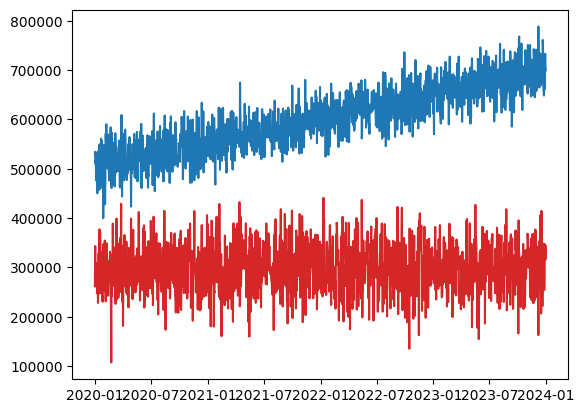

In [11]:
plot(df)

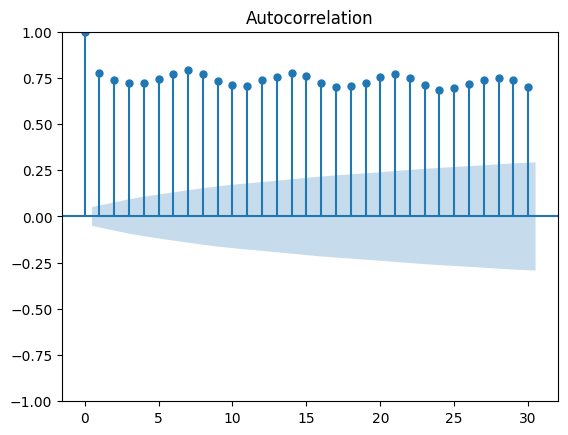

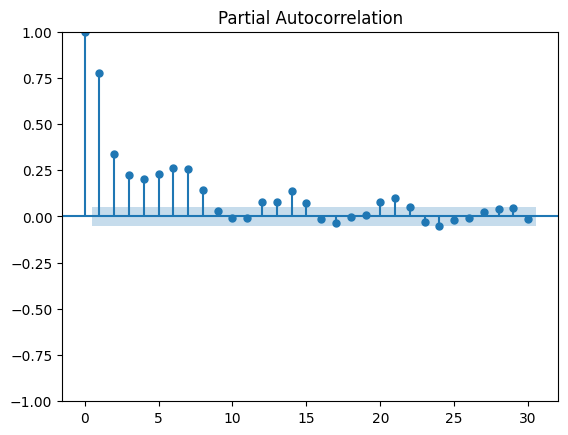

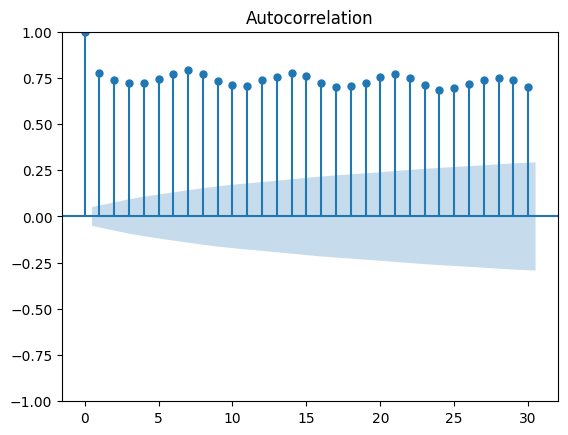

In [12]:
# pacf and acf plots
lag = 30
window = 8
plot_pacf(df['Pemasukan'], lags=lag)
plot_acf(df['Pemasukan'], lags=lag)

In [13]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['Pemasukan'])

print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

if result[1] < 0.05:
    print("stationary.")
else:
    print("non-stationary")


ADF Statistic: -0.7643665955643046
p-value: 0.8293657318726213
non-stationary


In [14]:
diff_pemasukan = df['Pemasukan'].diff().dropna()
result = adfuller(diff_pemasukan)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
if result[1] < 0.05:
    print("stationary.")
else:
    print("non-stationary")


ADF Statistic: -16.931562378716368
p-value: 9.76817423561865e-30
stationary.


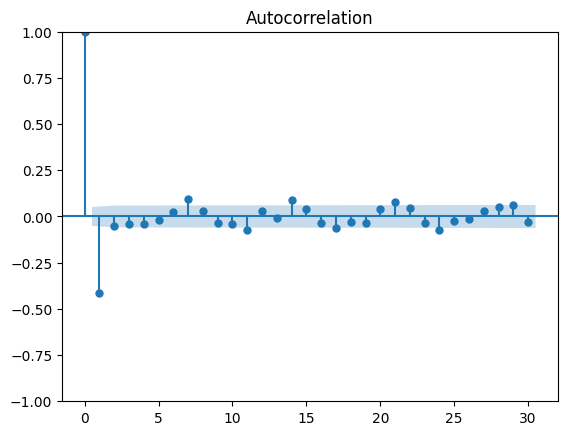

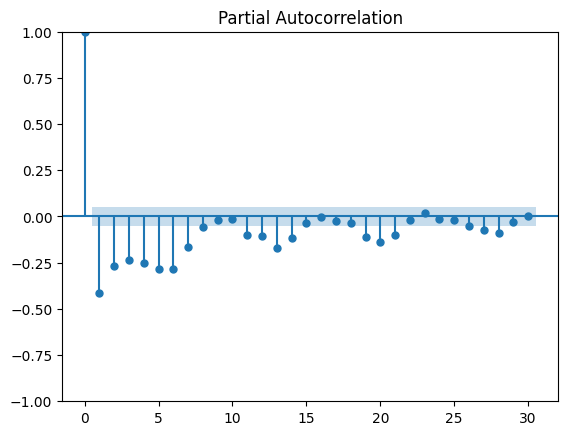

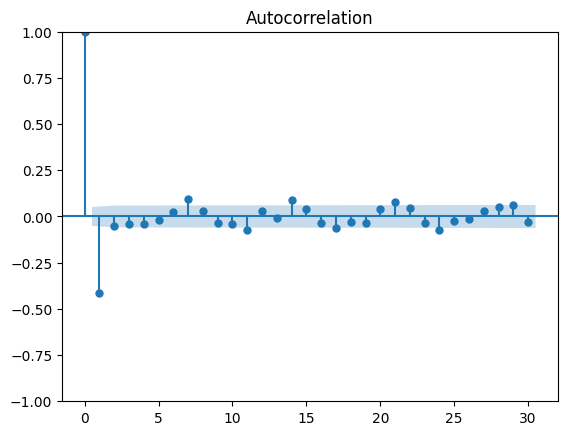

In [15]:
# pacf and acf plots
lag = 30
window = 8
plot_pacf(diff_pemasukan, lags=lag)
plot_acf(diff_pemasukan, lags=lag)

## Data Preprocessing

In [16]:
# # sliding window

# def create_sequences(data, window_size):
#     X, y = [], []
#     for i in range(len(data) - window_size):
#         X.append(data[i:i + window_size])
#         y.append(data[i + window_size])
#     return np.array(X), np.array(y)

def create_sequences(series, window, forecast_horizon=14):
    X, y = [], []
    n = len(series)
    for i in range(n - window - forecast_horizon + 1):
        X.append(series[i : i + window])
        y.append(series[i + window : i + window + forecast_horizon])

    X = np.array(X).reshape(-1, window, 1)
    y = np.array(y)
    return X, y

In [17]:
x, y = create_sequences(df['Pemasukan'], window, 14)

In [18]:
print(x.shape)
print(y.shape)

(1440, 8, 1)
(1440, 14)


In [19]:
scaler_x = StandardScaler()
scaler_y = StandardScaler()
samples, window, features = x.shape

x_reshaped = x.reshape(-1, features)
x_scaled_reshaped = scaler_x.fit_transform(x_reshaped)

x_scaled = x_scaled_reshaped.reshape(samples, window, features)
y_scaled = scaler_y.fit_transform(y)
print(x_scaled.shape)  # (1440, 8, 1)
print(y_scaled.shape)


(1440, 8, 1)
(1440, 14)


In [20]:
# Simpan hasil standarisasi menggunakan pickle
pickle.dump(x_scaled, open('x_scaled.pkl','wb'))
pickle.dump(y_scaled, open('y_scaled.pkl','wb'))

# Simpan objek scaler yang sudah fit
pickle.dump(scaler_x, open('scaler_x.pkl','wb'))
pickle.dump(scaler_y, open('scaler_y.pkl','wb'))

In [21]:
# Ubah 3 dimensi
x_scaled = x_scaled.reshape((x_scaled.shape[0], x_scaled.shape[1], 1))

# Split
X , x_test, Y, y_test = train_test_split(x_scaled, y_scaled, test_size=0.1, shuffle=False)
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.1, shuffle=False)


print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

(1166, 8, 1) (1166, 14)
(130, 8, 1) (130, 14)
(144, 8, 1) (144, 14)


## Modelling

In [22]:
def build_model(window):
  model = Sequential([
    layers.Conv1D(64, kernel_size=3, activation='relu',padding='same', input_shape=(window, 1)),
    layers.Conv1D(128, kernel_size=3, activation='relu', padding='same'),
    layers.Conv1D(256, kernel_size=3, activation='relu', padding='same'),
    layers.LSTM(256, input_shape=(window,1), return_sequences = True),
    layers.LSTM(128, input_shape=(window,1), return_sequences = True),
    layers.LSTM(64, return_sequences=True),
    layers.Dropout(0.3),
    layers.LSTM(32),
    layers.Dense(14)
  ])
  return model

In [23]:
model = build_model(lag)
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 30, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 30, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 30, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 30, 256)        │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 30, 128)        │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 30, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 14)             │           462 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 908,238 (3.46 MB)

 Trainable params: 908,238 (3.46 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
# Callback
early_stopping = EarlyStopping(monitor='val_mae', patience=10, restore_best_weights=True)

# Simpan model terbaik
model_checkpoint = ModelCheckpoint(
    filepath='model.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

In [25]:
model.compile(loss=MeanSquaredError(), optimizer='adam', metrics=['mae'])
history = model.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=(x_val, y_val), callbacks=[early_stopping, model_checkpoint])

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.5917 - mae: 0.6104
Epoch 1: val_loss improved from inf to 0.55888, saving model to model.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 20s 116ms/step - loss: 0.5879 - mae: 0.6083 - val_loss: 0.5589 - val_mae: 0.6306
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.2832 - mae: 0.4285
Epoch 2: val_loss improved from 0.55888 to 0.35930, saving model to model.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - loss: 0.2831 - mae: 0.4284 - val_loss: 0.3593 - val_mae: 0.4903
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 0.2769 - mae: 0.4225
Epoch 3: val_loss did not improve from 0.35930
37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 135ms/step - loss: 0.2768 - mae: 0.4225 - val_loss: 0.3616 - val_mae: 0.4931
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.2681 - mae: 0.4141
Epoch 4: val_loss improved from 0.35930 to 0.32432, saving model to model.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - loss: 0.2681 - mae: 0.4142 - val_loss: 0.3243 - val_mae: 0.4628
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.2684 - mae: 0.4133
Epoch 5: val_loss improved from 0.32432 to 0.30746, saving model to model.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - loss: 0.2685 - mae: 0.4133 - val_loss: 0.3075 - val_mae: 0.4499
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.2729 - mae: 0.4172
Epoch 6: val_loss did not improve from 0.30746
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - loss: 0.2728 - mae: 0.4171 - val_loss: 0.3296 - val_mae: 0.4686
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.2714 - mae: 0.4173
Epoch 7: val_loss did not improve from 0.30746
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - loss: 0.2713 - mae: 0.4172 - val_loss: 0.3205 - val_mae: 0.4607
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.2666 - mae: 0.4141
Epoch 8: val_loss improved from 0.30746 to 0.30663, saving model to model.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - loss: 0.2665 - mae: 0.4140 - val_loss: 0.3066 - val_mae: 0.4504
Epoch 9/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.2642 - mae: 0.4103
Epoch 9: val_loss did not improve from 0.30663
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - loss: 0.2641 - mae: 0.4103 - val_loss: 0.3226 - val_mae: 0.4628
Epoch 10/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.2597 - mae: 0.4070
Epoch 10: val_loss improved from 0.30663 to 0.29890, saving model to model.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - loss: 0.2598 - mae: 0.4070 - val_loss: 0.2989 - val_mae: 0.4446
Epoch 11/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.2675 - mae: 0.4139
Epoch 11: val_loss improved from 0.29890 to 0.28792, saving model to model.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - loss: 0.2675 - mae: 0.4138 - val_loss: 0.2879 - val_mae: 0.4334
Epoch 12/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.2647 - mae: 0.4110
Epoch 12: val_loss improved from 0.28792 to 0.28067, saving model to model.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.2646 - mae: 0.4109 - val_loss: 0.2807 - val_mae: 0.4281
Epoch 13/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 0.2554 - mae: 0.4044
Epoch 13: val_loss improved from 0.28067 to 0.27381, saving model to model.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - loss: 0.2554 - mae: 0.4043 - val_loss: 0.2738 - val_mae: 0.4231
Epoch 14/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.2533 - mae: 0.4022
Epoch 14: val_loss did not improve from 0.27381
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 0.2534 - mae: 0.4023 - val_loss: 0.3111 - val_mae: 0.4536
Epoch 15/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.2552 - mae: 0.4024
Epoch 15: val_loss did not improve from 0.27381
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - loss: 0.2552 - mae: 0.4024 - val_loss: 0.2749 - val_mae: 0.4233
Epoch 16/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.2503 - mae: 0.3975
Epoch 16: val_loss did not improve from 0.27381
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - loss: 0.2504 - mae: 0.3976 - val_loss: 0.2977 - val_mae: 0.4426
Epoch 17/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.2546 - mae: 0.4028
Epoch 17: val_loss did not improve from 0.27381
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.2545 - m

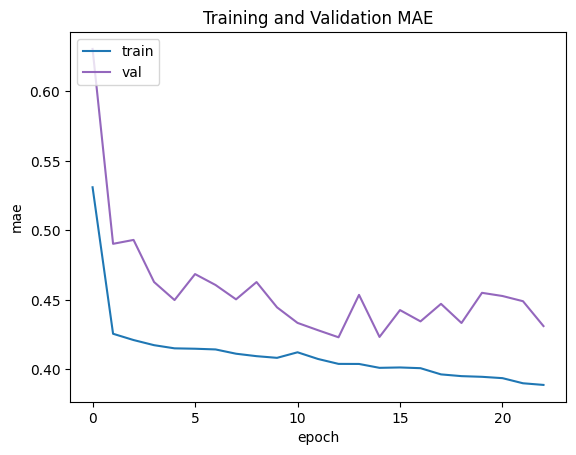

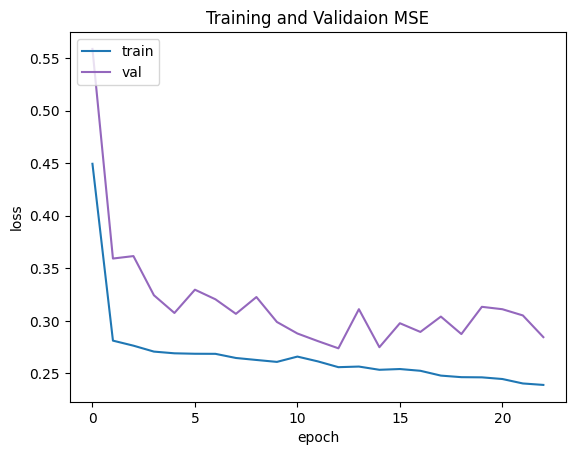

In [26]:
acc = history.history['mae']
val_acc = history.history['val_mae']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'tab:blue')
plt.plot(epochs, val_acc, 'tab:purple')
plt.title('Training and Validation MAE')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'tab:blue')
plt.plot(epochs, val_loss, 'tab:purple')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion MSE')
plt.show()

In [27]:
# eval
model.evaluate(x_test, y_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.4203 - mae: 0.5223


[0.4456897974014282, 0.5366349220275879]

In [28]:
# y_pred = model.predict(x_test)
# print(y_pred.shape)
# print(y_test.shape)

# y_test_flat = y_test.reshape(-1)
# y_pred_flat = y_pred.reshape(-1)

# min_len = min(len(y_test_flat), len(y_pred_flat))
# y_test_flat = y_test_flat[:min_len]
# y_pred_flat = y_pred_flat[:min_len]

# plt.plot(y_test_flat, label='y_test', color='tab:blue')
# plt.plot(y_pred_flat, label='y_pred', color='tab:red')
# plt.legend()
# plt.show()



# Inferences

In [29]:
def inference_lstm_latest(model_path, scaler_x_path, scaler_y_path, x_scaled_path, window):
    # Load model dan scaler
    model = load_model(model_path)
    scaler_x = pickle.load(open(scaler_x_path, 'rb'))
    scaler_y = pickle.load(open(scaler_y_path, 'rb'))

    # Load data x_scaled yang sudah disimpan (bukan scaler)
    x_scaled_all = pickle.load(open(x_scaled_path, 'rb'))

    # Pastikan data x_scaled_all 2D dan reshape jadi 1 fitur
    x_scaled_all = x_scaled_all.reshape(-1, 1)

    # Ambil data terakhir sebanyak 'window'
    if len(x_scaled_all) < window:
        raise ValueError(f"Data tidak cukup panjang, butuh minimal {window} baris")
    x_latest = x_scaled_all[-window:]

    # Bentuk input untuk LSTM: (1, window, 1)
    x_latest = x_latest.reshape(1, window, 1)

    # Prediksi output diskalakan
    y_pred_scaled = model.predict(x_latest)

    # Inverse transform hasil prediksi ke skala asli
    y_pred = scaler_y.inverse_transform(y_pred_scaled)

    return y_pred[0].tolist()

# Contoh penggunaan
prediksi_terbaru = inference_lstm_latest(
    model_path='model.h5',
    scaler_x_path='scaler_x.pkl',
    scaler_y_path='scaler_y.pkl',
    x_scaled_path='x_scaled.pkl',
    window=8
)
for i, nilai in enumerate(prediksi_terbaru, 1):
    print(f"Prediksi hari ke-{i}: {nilai:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 714ms/step
Prediksi hari ke-1: 663577.62
Prediksi hari ke-2: 667072.19
Prediksi hari ke-3: 662624.94
Prediksi hari ke-4: 669308.75
Prediksi hari ke-5: 664005.00
Prediksi hari ke-6: 664643.19
Prediksi hari ke-7: 666277.69
Prediksi hari ke-8: 657465.50
Prediksi hari ke-9: 657696.44
Prediksi hari ke-10: 663330.62
Prediksi hari ke-11: 666337.19
Prediksi hari ke-12: 666489.62
Prediksi hari ke-13: 663703.56
Prediksi hari ke-14: 663819.06


In [30]:
y_inv = scaler_y.inverse_transform(y_test)
print(y_inv)

[[688615.61025272 663341.76984489 687363.16111377 ... 647667.68272258
  665591.54556791 613688.6019433 ]
 [663341.76984489 687363.16111377 701261.84552527 ... 665591.54556791
  613688.6019433  712197.56502479]
 [687363.16111377 701261.84552527 677641.86237982 ... 613688.6019433
  712197.56502479 663996.04099856]
 ...
 [720023.98858608 707016.24303631 678917.07957269 ... 660910.22180199
  705294.94071901 732865.7175334 ]
 [707016.24303631 678917.07957269 698992.25382016 ... 705294.94071901
  732865.7175334  706555.71044459]
 [678917.07957269 698992.25382016 674224.23389716 ... 732865.7175334
  706555.71044459 699088.95068903]]


[663577.625, 667072.1875, 662624.9375, 669308.75, 664005.0, 664643.1875, 666277.6875, 657465.5, 657696.4375, 663330.625, 666337.1875, 666489.625, 663703.5625, 663819.0625]


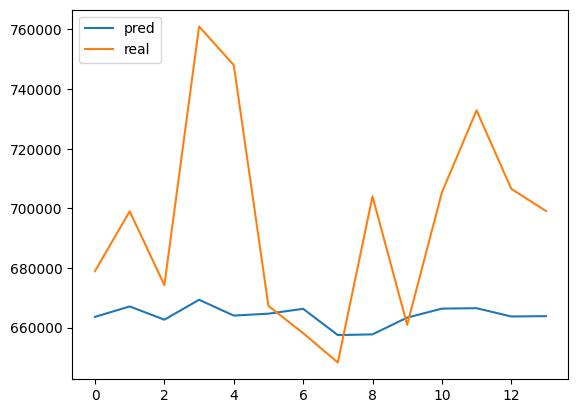

In [31]:
print(prediksi_terbaru)
plt.plot(prediksi_terbaru, label ='pred')
plt.plot(y_inv[-1], label='real')
plt.legend(['pred', 'real'], loc='upper left')
plt.show()

In [32]:
# model 2

In [33]:
def make_dataset(data, window):
    x, y = [], []
    for i in range(len(data) - window):
        x.append(data[i:i+window])
        y.append(data[i+window])
    return np.array(x), np.array(y)


In [34]:
x2, y2 = make_dataset(df['Pemasukan'], window=14)
x2 = x2.reshape(-1, 14, 1)
y2 = y2.reshape(-1, 1)

print(x2.shape)
print(y2.shape)

(1447, 14, 1)
(1447, 1)


<ipython-input-33-21dced859a60>:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i+window])


In [35]:
scaler_x2 = StandardScaler()
scaler_y2 = StandardScaler()
samples2, window2, features2 = x2.shape

x_reshaped2 = x2.reshape(-1, features2)
x_scaled_reshaped2 = scaler_x2.fit_transform(x_reshaped2)

x_scaled2 = x_scaled_reshaped2.reshape(samples2, window2, features2)
y_scaled2 = scaler_y2.fit_transform(y2)
print(x_scaled2.shape)
print(y_scaled2.shape)

(1447, 14, 1)
(1447, 1)


In [36]:
# Simpan hasil standarisasi menggunakan pickle
pickle.dump(x_scaled2, open('x_scaled2.pkl','wb'))
pickle.dump(y_scaled2, open('y_scaled2.pkl','wb'))

# Simpan objek scaler yang sudah fit
pickle.dump(scaler_x2, open('scaler_x2.pkl','wb'))
pickle.dump(scaler_y2, open('scaler_y2.pkl','wb'))

In [37]:
# Ubah 3 dimensi
x_scaled2 = x_scaled2.reshape((x_scaled2.shape[0], x_scaled2.shape[1], 1))

# Split
X2 , x_test2, Y2, y_test2 = train_test_split(x_scaled2, y_scaled2, test_size=0.1, shuffle=False)
x_train2, x_val2, y_train2, y_val2 = train_test_split(X2, Y2, test_size=0.1, shuffle=False)


print(x_train2.shape, y_train.shape)
print(x_val2.shape, y_val.shape)
print(x_test2.shape, y_test.shape)

(1171, 14, 1) (1166, 14)
(131, 14, 1) (130, 14)
(145, 14, 1) (144, 14)


In [38]:
def build_model2(window):
    model = Sequential([
        layers.Conv1D(64, kernel_size=3, activation='relu',padding='same', input_shape=(window, 1)),
        layers.Conv1D(128, kernel_size=3, activation='relu', padding='same'),
        layers.Conv1D(256, kernel_size=3, activation='relu', padding='same'),
        layers.LSTM(256, return_sequences=True),
        layers.LSTM(128, return_sequences=True),
        layers.Dropout(0.3),
        layers.LSTM(64, return_sequences=True),
        layers.Dropout(0.2),
        layers.LSTM(32, return_sequences=True),
        layers.TimeDistributed(layers.Dense(1))
    ])
    return model

In [39]:
model2 = build_model2(window2)
model2.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 14, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 14, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 14, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 14, 256)        │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 14, 128)        │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 14, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 14, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 14, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 14, 32)         │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 14, 1)          │            33 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 907,809 (3.46 MB)

 Trainable params: 907,809 (3.46 MB)

 Non-trainable params: 0 (0.00 B)

In [40]:
# Callback
early_stopping = EarlyStopping(monitor='val_mae', patience=10, restore_best_weights=True)

# Simpan model terbaik
model_checkpoint = ModelCheckpoint(
    filepath='model2.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

In [41]:
model2.compile(loss=MeanSquaredError(), optimizer='adam', metrics=['mae'])
history2 = model2.fit(x_train2, y_train2, epochs=50, batch_size=32, validation_data=(x_val2, y_val2), callbacks=[early_stopping, model_checkpoint])

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.5608 - mae: 0.5938
Epoch 1: val_loss improved from inf to 0.73524, saving model to model2.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 17s 188ms/step - loss: 0.5580 - mae: 0.5922 - val_loss: 0.7352 - val_mae: 0.7372
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.3362 - mae: 0.4623
Epoch 2: val_loss improved from 0.73524 to 0.60456, saving model to model2.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - loss: 0.3364 - mae: 0.4624 - val_loss: 0.6046 - val_mae: 0.6501
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.3042 - mae: 0.4366
Epoch 3: val_loss improved from 0.60456 to 0.54942, saving model to model2.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - loss: 0.3041 - mae: 0.4367 - val_loss: 0.5494 - val_mae: 0.6135
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - loss: 0.2984 - mae: 0.4394
Epoch 4: val_loss improved from 0.54942 to 0.43690, saving model to model2.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 179ms/step - loss: 0.2982 - mae: 0.4392 - val_loss: 0.4369 - val_mae: 0.5344
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.2994 - mae: 0.4408
Epoch 5: val_loss improved from 0.43690 to 0.43439, saving model to model2.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 154ms/step - loss: 0.2990 - mae: 0.4404 - val_loss: 0.4344 - val_mae: 0.5361
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.2637 - mae: 0.4117
Epoch 6: val_loss did not improve from 0.43439
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 150ms/step - loss: 0.2640 - mae: 0.4119 - val_loss: 0.4765 - val_mae: 0.5704
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 0.2888 - mae: 0.4231
Epoch 7: val_loss improved from 0.43439 to 0.41609, saving model to model2.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 11s 180ms/step - loss: 0.2887 - mae: 0.4231 - val_loss: 0.4161 - val_mae: 0.5269
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 0.2540 - mae: 0.4023
Epoch 8: val_loss improved from 0.41609 to 0.40974, saving model to model2.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 139ms/step - loss: 0.2544 - mae: 0.4026 - val_loss: 0.4097 - val_mae: 0.5245
Epoch 9/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.2628 - mae: 0.4096
Epoch 9: val_loss improved from 0.40974 to 0.38036, saving model to model2.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - loss: 0.2629 - mae: 0.4097 - val_loss: 0.3804 - val_mae: 0.5026
Epoch 10/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 0.2496 - mae: 0.3998
Epoch 10: val_loss did not improve from 0.38036
37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 176ms/step - loss: 0.2501 - mae: 0.4002 - val_loss: 0.5450 - val_mae: 0.6192
Epoch 11/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.2473 - mae: 0.3994
Epoch 11: val_loss did not improve from 0.38036
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 136ms/step - loss: 0.2479 - mae: 0.3998 - val_loss: 0.5504 - val_mae: 0.6295
Epoch 12/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - loss: 0.2689 - mae: 0.4210
Epoch 12: val_loss improved from 0.38036 to 0.36948, saving model to model2.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 185ms/step - loss: 0.2689 - mae: 0.4208 - val_loss: 0.3695 - val_mae: 0.4957
Epoch 13/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 0.2570 - mae: 0.4017
Epoch 13: val_loss improved from 0.36948 to 0.31680, saving model to model2.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 165ms/step - loss: 0.2571 - mae: 0.4018 - val_loss: 0.3168 - val_mae: 0.4545
Epoch 14/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.2542 - mae: 0.3993
Epoch 14: val_loss did not improve from 0.31680
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - loss: 0.2542 - mae: 0.3994 - val_loss: 0.4462 - val_mae: 0.5561
Epoch 15/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 0.2704 - mae: 0.4204
Epoch 15: val_loss did not improve from 0.31680
37/37 ━━━━━━━━━━━━━━━━━━━━ 11s 173ms/step - loss: 0.2703 - mae: 0.4202 - val_loss: 0.3333 - val_mae: 0.4670
Epoch 16/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.2525 - mae: 0.3962
Epoch 16: val_loss did not improve from 0.31680
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 151ms/step - loss: 0.2531 - mae: 0.3968 - val_loss: 0.4423 - val_mae: 0.5511
Epoch 17/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.2521 - mae: 0.3991
Epoch 17: val_loss did not improve from 0.31680
37/37 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step - loss: 0

37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 168ms/step - loss: 0.2471 - mae: 0.3957 - val_loss: 0.3074 - val_mae: 0.4464
Epoch 21/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 0.2441 - mae: 0.3901
Epoch 21: val_loss improved from 0.30742 to 0.28790, saving model to model2.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 10s 169ms/step - loss: 0.2443 - mae: 0.3904 - val_loss: 0.2879 - val_mae: 0.4311
Epoch 22/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.2495 - mae: 0.3964
Epoch 22: val_loss did not improve from 0.28790
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 136ms/step - loss: 0.2495 - mae: 0.3964 - val_loss: 0.3322 - val_mae: 0.4666
Epoch 23/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 0.2394 - mae: 0.3891
Epoch 23: val_loss did not improve from 0.28790
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 174ms/step - loss: 0.2397 - mae: 0.3892 - val_loss: 0.3443 - val_mae: 0.4755
Epoch 24/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.2362 - mae: 0.3827
Epoch 24: val_loss did not improve from 0.28790
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - loss: 0.2366 - mae: 0.3831 - val_loss: 0.3557 - val_mae: 0.4857
Epoch 25/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 0.2460 - mae: 0.3938
Epoch 25: val_loss improved from 0.28790 to 0.26945, saving model to model2.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 171ms/step - loss: 0.2460 - mae: 0.3937 - val_loss: 0.2694 - val_mae: 0.4179
Epoch 26/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 0.2300 - mae: 0.3797
Epoch 26: val_loss did not improve from 0.26945
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 138ms/step - loss: 0.2302 - mae: 0.3799 - val_loss: 0.2771 - val_mae: 0.4214
Epoch 27/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 0.2277 - mae: 0.3796
Epoch 27: val_loss did not improve from 0.26945
37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 178ms/step - loss: 0.2280 - mae: 0.3799 - val_loss: 0.3111 - val_mae: 0.4478
Epoch 28/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 0.2413 - mae: 0.3892
Epoch 28: val_loss did not improve from 0.26945
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 141ms/step - loss: 0.2415 - mae: 0.3894 - val_loss: 0.4319 - val_mae: 0.5468
Epoch 29/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 0.2411 - mae: 0.3889
Epoch 29: val_loss improved from 0.26945 to 0.26013, saving model to model2.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 10s 140ms/step - loss: 0.2410 - mae: 0.3889 - val_loss: 0.2601 - val_mae: 0.4071
Epoch 30/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 0.2429 - mae: 0.3891
Epoch 30: val_loss did not improve from 0.26013
37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 178ms/step - loss: 0.2426 - mae: 0.3889 - val_loss: 0.4106 - val_mae: 0.5277
Epoch 31/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.2218 - mae: 0.3749
Epoch 31: val_loss did not improve from 0.26013
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 137ms/step - loss: 0.2223 - mae: 0.3753 - val_loss: 0.4083 - val_mae: 0.5282
Epoch 32/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.2301 - mae: 0.3810
Epoch 32: val_loss did not improve from 0.26013
37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 173ms/step - loss: 0.2302 - mae: 0.3810 - val_loss: 0.3395 - val_mae: 0.4709
Epoch 33/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.2423 - mae: 0.3859
Epoch 33: val_loss did not improve from 0.26013
37/37 ━━━━━━━━━━━━━━━━━━━━ 10s 176ms/step - loss: 0

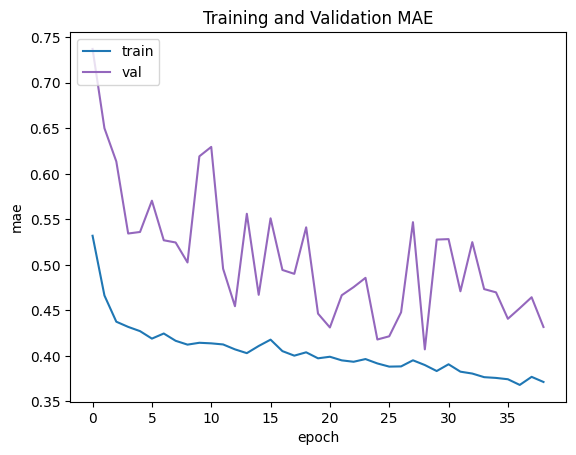

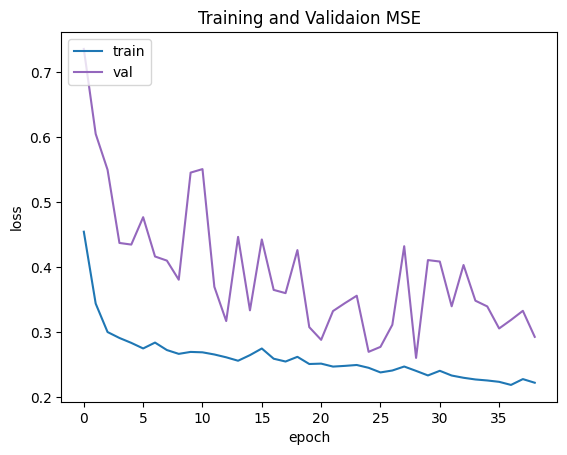

In [42]:
acc = history2.history['mae']
val_acc = history2.history['val_mae']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'tab:blue')
plt.plot(epochs, val_acc, 'tab:purple')
plt.title('Training and Validation MAE')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'tab:blue')
plt.plot(epochs, val_loss, 'tab:purple')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion MSE')
plt.show()

In [43]:
def inference_lstm_latest2(model_path, scaler_x_path, scaler_y_path, x_scaled_path, window):
    # Load model dan scaler
    model = load_model(model_path)
    scaler_x = pickle.load(open(scaler_x_path, 'rb'))
    scaler_y = pickle.load(open(scaler_y_path, 'rb'))

    # Load data x_scaled yang sudah disimpan
    x_scaled_all = pickle.load(open(x_scaled_path, 'rb'))
    x_scaled_all = x_scaled_all.reshape(-1, 1)

    # Ambil window terakhir
    if len(x_scaled_all) < window:
        raise ValueError(f"Data tidak cukup panjang, butuh minimal {window} baris")
    x_latest = x_scaled_all[-window:]

    # Bentuk input: (1, window, 1)
    x_latest = x_latest.reshape(1, window, 1)

    # Prediksi
    y_pred_scaled = model.predict(x_latest)

    # Reshape ke (14, 1) agar cocok untuk inverse_transform
    y_pred_scaled = y_pred_scaled.reshape(-1, 1)

    # Balik ke skala asli
    y_pred = scaler_y.inverse_transform(y_pred_scaled)

    return y_pred.flatten()

prediksi_terbaru2 = inference_lstm_latest2(
    model_path='model2.h5',
    scaler_x_path='scaler_x2.pkl',
    scaler_y_path='scaler_y2.pkl',
    x_scaled_path='x_scaled2.pkl',
    window=14
)

for i, nilai in enumerate(prediksi_terbaru2, 1):
    print(f"Prediksi hari ke-{i}: {nilai:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 815ms/step
Prediksi hari ke-1: 653247.69
Prediksi hari ke-2: 647908.62
Prediksi hari ke-3: 665175.00
Prediksi hari ke-4: 663486.81
Prediksi hari ke-5: 664354.50
Prediksi hari ke-6: 664842.62
Prediksi hari ke-7: 666203.06
Prediksi hari ke-8: 667066.75
Prediksi hari ke-9: 666919.56
Prediksi hari ke-10: 666655.25
Prediksi hari ke-11: 666316.75
Prediksi hari ke-12: 665152.94
Prediksi hari ke-13: 663472.06
Prediksi hari ke-14: 661404.56


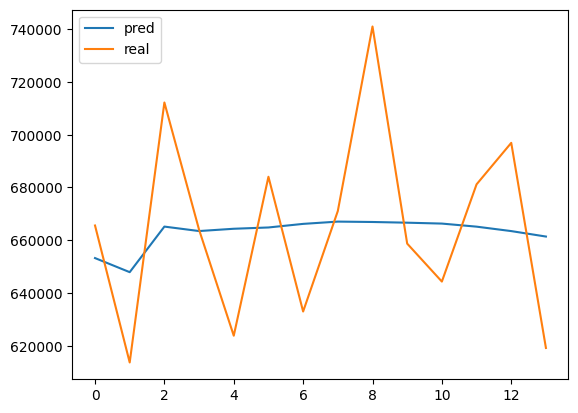

In [44]:
y_inv2 = scaler_y2.inverse_transform(y_test2)

plt.plot(prediksi_terbaru2, label ='pred')
plt.plot(y_inv2[:14], label='real')
plt.legend(['pred', 'real'], loc='upper left')
plt.show()

In [45]:
y_test2[:14].shape

(14, 1)

# pengeluaran - memakai model 1 karena lebih beperforma

In [46]:
# model 1 dengan pengeluaaran

In [47]:
x_pengeluaran, y_pengeluaran =create_sequences(df['Pengeluaran'], window, 14)
samples_pengeluaran, window_pengeluaran, features_pengeluaran = x_pengeluaran.shape

scaler_pengeluaran_x = StandardScaler()
scaler_pengeluaran_y = StandardScaler()
x_reshaped_pengeluaran = x_pengeluaran.reshape(-1, features_pengeluaran)
x_scaled_reshaped_pengeluaran = scaler_pengeluaran_x.fit_transform(x_reshaped_pengeluaran)
y_scaled = scaler_pengeluaran_y.fit_transform(y_pengeluaran)

x_scaled_pengeluaran = x_scaled_reshaped_pengeluaran.reshape(samples, window, features)
x_scaled_pengeluaran = x_scaled_pengeluaran.reshape((x_scaled.shape[0], x_scaled.shape[1], 1))

pickle.dump(scaler_pengeluaran_x, open('scaler_x_pengeluaran.pkl','wb'))
pickle.dump(scaler_pengeluaran_y, open('scaler_y_pengeluaran.pkl','wb'))

In [48]:
x_scaled

array([[[-1.02082019],
        [-1.19086295],
        [-1.38508499],
        ...,
        [-1.03493423],
        [-1.85743617],
        [-1.56601434]],

       [[-1.19086295],
        [-1.38508499],
        [-1.27575067],
        ...,
        [-1.85743617],
        [-1.56601434],
        [-2.30944902]],

       [[-1.38508499],
        [-1.27575067],
        [-1.9068603 ],
        ...,
        [-1.56601434],
        [-2.30944902],
        [-1.31105371]],

       ...,

       [[ 1.69666546],
        [ 1.53023099],
        [ 1.00168734],
        ...,
        [ 2.06954222],
        [ 1.06493945],
        [ 1.70309093]],

       [[ 1.53023099],
        [ 1.00168734],
        [ 1.26349786],
        ...,
        [ 1.06493945],
        [ 1.70309093],
        [ 1.85911607]],

       [[ 1.00168734],
        [ 1.26349786],
        [ 1.5529319 ],
        ...,
        [ 1.70309093],
        [ 1.85911607],
        [ 1.6581137 ]]])

In [49]:
x_scaled_pengeluaran

array([[[-0.73588991],
        [ 0.91657679],
        [-0.39177092],
        ...,
        [-0.0450597 ],
        [-0.20954359],
        [-1.02447203]],

       [[ 0.91657679],
        [-0.39177092],
        [-0.22124877],
        ...,
        [-0.20954359],
        [-1.02447203],
        [-0.53734171]],

       [[-0.39177092],
        [-0.22124877],
        [ 0.21324823],
        ...,
        [-1.02447203],
        [-0.53734171],
        [-0.14728555]],

       ...,

       [[-1.20174146],
        [ 1.09986045],
        [-0.30049449],
        ...,
        [ 2.17346828],
        [ 1.65636078],
        [-0.75563235]],

       [[ 1.09986045],
        [-0.30049449],
        [ 0.05796877],
        ...,
        [ 1.65636078],
        [-0.75563235],
        [-1.86054714]],

       [[-0.30049449],
        [ 0.05796877],
        [ 0.97807766],
        ...,
        [-0.75563235],
        [-1.86054714],
        [ 2.36312718]]])

In [50]:
def inference_lstm_pengeluaran(model_path, scaler_x_path, scaler_y_path, x_test, window):
    # Load model dan scaler
    model = load_model(model_path)
    scaler_x = pickle.load(open(scaler_x_path, 'rb'))
    scaler_y = pickle.load(open(scaler_y_path, 'rb'))

    # Load data x_scaled yang sudah disimpan (bukan scaler)
    x_scaled_all = x_test

    # Pastikan data x_scaled_all 2D dan reshape jadi 1 fitur
    x_scaled_all = x_scaled_all.reshape(-1, 1)

    # Ambil data terakhir sebanyak 'window'
    if len(x_scaled_all) < window:
        raise ValueError(f"Data tidak cukup panjang, butuh minimal {window} baris")
    x_latest = x_scaled_all[-window:]

    # Bentuk input untuk LSTM: (1, window, 1)
    x_latest = x_latest.reshape(1, window, 1)

    # Prediksi output diskalakan
    y_pred_scaled = model.predict(x_latest)

    # Inverse transform hasil prediksi ke skala asli
    y_pred = scaler_y.inverse_transform(y_pred_scaled)

    return y_pred[0].tolist()

# Contoh penggunaan
prediksi_pengeluaran = inference_lstm_pengeluaran(
    model_path='model.h5',
    scaler_x_path='scaler_x_pengeluaran.pkl',
    scaler_y_path='scaler_y_pengeluaran.pkl',
    x_test = x_scaled_pengeluaran,
    window=8
)
for i, nilai in enumerate(prediksi_pengeluaran, 1):
    print(f"Prediksi hari ke-{i}: {nilai:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 765ms/step
Prediksi hari ke-1: 330928.81
Prediksi hari ke-2: 342986.72
Prediksi hari ke-3: 338770.59
Prediksi hari ke-4: 331724.66
Prediksi hari ke-5: 325128.56
Prediksi hari ke-6: 318525.72
Prediksi hari ke-7: 325906.09
Prediksi hari ke-8: 333818.66
Prediksi hari ke-9: 339130.31
Prediksi hari ke-10: 337683.91
Prediksi hari ke-11: 332233.94
Prediksi hari ke-12: 325672.91
Prediksi hari ke-13: 324868.53
Prediksi hari ke-14: 327732.44


# Hasil prediksi Penghasilan dan Pengeluaran

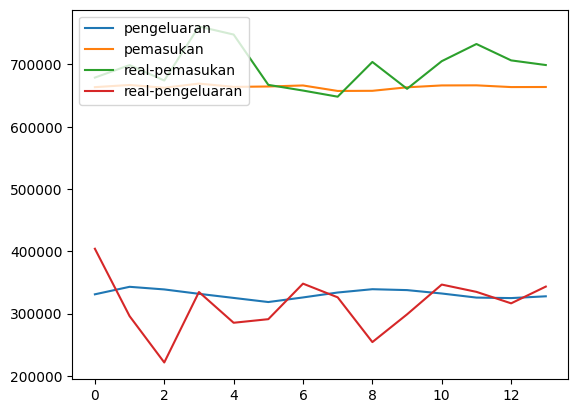

In [51]:
y_inv3 = y_pengeluaran[-1]

plt.plot(prediksi_pengeluaran, label ='pred_pengeluaran')
plt.plot(prediksi_terbaru, label ='pred_pemasukan')
plt.plot(y_inv[-1], label='pemasukan')
plt.plot(y_inv3, label='pengeluaran')
plt.legend(['pengeluaran', 'pemasukan','real-pemasukan', 'real-pengeluaran'], loc='upper left')
plt.show()

In [52]:
y_inv3[-1].shape

()

# saving hasil scaling dan model

In [53]:
# jangan di run kecuali dah mau save model

In [54]:
#connect ke drive

In [55]:
# from google.colab import drive
# drive.mount('/content/drive')


In [56]:
# import os

# save_dir = '/content/drive/MyDrive/lstm_forecast'
# os.makedirs(save_dir, exist_ok=True)

In [57]:
# model.save(os.path.join(save_dir, 'model.h5'))

# with open(os.path.join(save_dir, 'scaler_x.pkl'), 'wb') as f:
#     pickle.dump(scaler_x, f)

# with open(os.path.join(save_dir, 'scaler_y.pkl'), 'wb') as f:
#     pickle.dump(scaler_y, f)

In [58]:
# with open(os.path.join(save_dir, 'scaler_x_pengeluaran.pkl'), 'wb') as f:
#     pickle.dump(scaler_pengeluaran_x, f)
# with open(os.path.join(save_dir, 'scaler_y_pengeluaran.pkl'), 'wb') as f:
#     pickle.dump(scaler_pengeluaran_y, f)